<a href="https://colab.research.google.com/github/devanandini0210/zinc_detector/blob/main/Faster_R_CNN_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mounting google drive and unzipping the dataset zip file
from google.colab import drive
drive.mount('/content/drive')

!unzip -q "/content/drive/MyDrive/Master_Thesis/dataset.zip" -d /content/

Mounted at /content/drive


In [ ]:
import os
import cv2
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

#defining the datatset function
class YOLODataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_paths = sorted([
            os.path.join(image_dir, f) for f in os.listdir(image_dir)
            if f.lower().endswith(('.jpg', '.png'))
        ])
        self.label_paths = [
            os.path.join(label_dir, os.path.splitext(os.path.basename(p))[0] + ".txt")
            for p in self.image_paths
        ]
        self.transforms = transforms or ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
      image = cv2.imread(self.image_paths[idx])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      h, w = image.shape[:2]

      boxes, labels = [], []
      with open(self.label_paths[idx], "r") as f:
          for line in f:
              parts = line.strip().split()
              if len(parts) != 5:
                  continue
              cls, xc, yc, bw, bh = map(float, parts)
              x1 = (xc - bw / 2) * w
              y1 = (yc - bh / 2) * h
              x2 = (xc + bw / 2) * w
              y2 = (yc + bh / 2) * h

              if x2 <= x1 or y2 <= y1:  #skipping the invalid boxes
                  continue

              boxes.append([x1, y1, x2, y2])
              labels.append(int(cls) + 1)

      if len(boxes) == 0:
          return None  #skipping the samples with no valid boxes

      target = {
          "boxes": torch.tensor(boxes, dtype=torch.float32),
          "labels": torch.tensor(labels, dtype=torch.int64),
          "image_id": torch.tensor(idx)
      }

      image = self.transforms(image)
      return image, target

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

#defining the model function
def get_model(num_classes=2):
    model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
train_img_dir = "/content/dataset/images/train"
train_lbl_dir = "/content/dataset/labels/train"
val_img_dir   = "/content/dataset/images/val"
val_lbl_dir   = "/content/dataset/labels/val"

#creating the training and validation datasets
train_dataset = YOLODataset(train_img_dir, train_lbl_dir, transforms=ToTensor())
val_dataset   = YOLODataset(val_img_dir, val_lbl_dir, transforms=ToTensor())

In [ ]:
from torch.utils.data import DataLoader
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    return tuple(zip(*batch))

#creating the training and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [ ]:
#initialising the model and other parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=2).to(device)

optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad],
                            lr=0.005, momentum=0.9, weight_decay=0.0005)


model.train()

best_loss= float('inf')

#training the model
for epoch in range(20):
    model.train()
    total_loss = 0.0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_avg_loss = total_loss / len(train_loader)

    #validating the model
    def evaluate_val_loss(model, val_loader, device):
      model.train()
      total_val_loss = 0.0

      with torch.no_grad():  # avoid gradient tracking
          for images, targets in val_loader:
              images = [img.to(device) for img in images]
              targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

              loss_dict = model(images, targets)
              loss = sum(loss_dict.values())
              total_val_loss += loss.item()

      return total_val_loss / len(val_loader)

    val_avg_loss = evaluate_val_loss(model, val_loader, device)
    print(f"Epoch {epoch+1} — Train Loss: {train_avg_loss:.4f}, Val Loss: {val_avg_loss:.4f}")

    #saving the best model
    if val_avg_loss < best_loss:
      best_loss = val_avg_loss
      torch.save(model.state_dict(), "fasterrcnn_best.pth")
      print(f"Best model saved (val loss: {best_loss:.4f})")

Epoch 1 — Train Loss: 0.3808, Val Loss: 0.3810
Best model saved (val loss: 0.3810)
Epoch 2 — Train Loss: 0.2777, Val Loss: 0.2736
Best model saved (val loss: 0.2736)
Epoch 3 — Train Loss: 0.2337, Val Loss: 0.2492
Best model saved (val loss: 0.2492)
Epoch 4 — Train Loss: 0.2073, Val Loss: 0.2482
Best model saved (val loss: 0.2482)
Epoch 5 — Train Loss: 0.1865, Val Loss: 0.2338
Best model saved (val loss: 0.2338)
Epoch 6 — Train Loss: 0.1727, Val Loss: 0.2320
Best model saved (val loss: 0.2320)
Epoch 7 — Train Loss: 0.1610, Val Loss: 0.2558
Epoch 8 — Train Loss: 0.1505, Val Loss: 0.2338
Epoch 9 — Train Loss: 0.1422, Val Loss: 0.2308
Best model saved (val loss: 0.2308)
Epoch 10 — Train Loss: 0.1350, Val Loss: 0.2221
Best model saved (val loss: 0.2221)
Epoch 11 — Train Loss: 0.1280, Val Loss: 0.2411
Epoch 12 — Train Loss: 0.1232, Val Loss: 0.2151
Best model saved (val loss: 0.2151)
Epoch 13 — Train Loss: 0.1174, Val Loss: 0.2281
Epoch 14 — Train Loss: 0.1149, Val Loss: 0.2259
Epoch 15 — Tr

In [ ]:
#downloading the best model
from google.colab import files
files.download("fasterrcnn_best.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_img_dir = "/content/dataset/images/test"
test_lbl_dir = "/content/dataset/labels/test"

#initialising the test dataset and dataloader
test_dataset = YOLODataset(test_img_dir, test_lbl_dir)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [ ]:
def get_model_size_params(model):
    import os
    torch.save(model.state_dict(), "temp.p")
    size_mb = os.path.getsize("temp.p") / 1e6
    os.remove("temp.p")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model Size: {size_mb:.2f} MB")
    print(f"Total Parameters: {total_params}")
    print(f"Trainable Parameters: {trainable_params}")


In [ ]:
import time
from collections import defaultdict
from torchvision.ops import box_iou

#evaluating the model on the test set
def evaluate_detailed(model, dataloader, device, iou_threshold=0.5, num_classes=2):
    model.eval()
    all_preds = defaultdict(list)
    all_gts = defaultdict(list)
    total_tp = total_fp = total_fn = 0
    inference_times = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            start = time.time()
            outputs = model(images)
            end = time.time()

            inference_times.append(end - start)

            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes']
                pred_labels = output['labels']
                pred_scores = output['scores']
                gt_boxes = target['boxes']
                gt_labels = target['labels']

                for cls in range(1, num_classes):
                    pred_mask = pred_labels == cls
                    gt_mask = gt_labels == cls

                    preds = pred_boxes[pred_mask]
                    scores = pred_scores[pred_mask]
                    gts = gt_boxes[gt_mask]

                    all_preds[cls].append((preds.cpu(), scores.cpu()))
                    all_gts[cls].append(gts.cpu())

                ious = box_iou(pred_boxes, gt_boxes)
                matched_gt = set()
                tp = 0
                for i in range(len(pred_boxes)):
                    iou_vals = ious[i]
                    max_iou, max_idx = torch.max(iou_vals, dim=0)
                    if max_iou >= iou_threshold and max_idx.item() not in matched_gt:
                        tp += 1
                        matched_gt.add(max_idx.item())

                fp = len(pred_boxes) - tp
                fn = len(gt_boxes) - tp
                total_tp += tp
                total_fp += fp
                total_fn += fn

    #calculatinh Precision, Recall, and F1
    precision = total_tp / (total_tp + total_fp + 1e-6)
    recall = total_tp / (total_tp + total_fn + 1e-6)
    f1_score = 2 * precision * recall / (precision + recall + 1e-6)
    avg_inference = sum(inference_times) / len(inference_times)
    fps = 1.0 / avg_inference

    #calculating mAP and AP per class
    def compute_ap(gt, pred, iou_thresh=0.5):
        if len(gt) == 0 and len(pred[0]) == 0:
            return 1.0
        if len(gt) == 0 or len(pred[0]) == 0:
            return 0.0
        preds, scores = pred
        preds = preds[scores > 0.05]
        if len(preds) == 0:
            return 0.0
        ious = box_iou(preds, gt)
        matched = set()
        tp = 0
        for i in range(len(preds)):
            max_iou, max_idx = torch.max(ious[i], dim=0)
            if max_iou >= iou_thresh and max_idx.item() not in matched:
                tp += 1
                matched.add(max_idx.item())
        fp = len(preds) - tp
        fn = len(gt) - tp
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        return (precision * recall) / (precision + recall + 1e-6)

    ap_per_class = {}
    for cls in range(1, num_classes):
        aps = []
        for gt, pred in zip(all_gts[cls], all_preds[cls]):
            ap = compute_ap(gt, pred)
            aps.append(ap)
        ap_avg = sum(aps) / len(aps) if aps else 0.0
        ap_per_class[cls] = ap_avg

    map_val = sum(ap_per_class.values()) / len(ap_per_class) if ap_per_class else 0.0

    #printing the results
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    print(f"mAP@0.5: {map_val:.4f}")
    print(f"Inference Time: {avg_inference:.4f} sec/image")
    print(f"FPS: {fps:.2f} frames/sec")
    print(f"\nAP per Class:")
    for cls, ap in ap_per_class.items():
        print(f"  Class {cls}: AP = {ap:.4f}")

In [ ]:
model = get_model(num_classes=2).to(device)
model.load_state_dict(torch.load("fasterrcnn_best.pth"))
get_model_size_params(model)
evaluate_detailed(model, test_loader, device, iou_threshold=0.5, num_classes=2)

<ipython-input-73-633f354175fb>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fasterrcnn_best.pth"))


Model Size: 165.71 MB
Total Parameters: 41299161
Trainable Parameters: 41076761
Precision: 0.8780
Recall: 0.9510
F1 Score: 0.9130
mAP@0.5: 0.4593
Inference Time: 0.0743 sec/image
FPS: 13.45 frames/sec

AP per Class:
  Class 1: AP = 0.4593


In [ ]:
from torchvision.ops import box_iou
import numpy as np
from collections import defaultdict
import torch

#function to collect data for visualisations
def evaluate_and_collect(model, dataloader, device, num_classes=2, iou_thresh=0.5):
    model.eval()

    all_confidences = []
    all_ious = []
    pr_data = defaultdict(list)
    confusion_counts = torch.zeros(num_classes, num_classes)  # [true, pred]
    heatmap_fp = []
    heatmap_fn = []
    all_pred_boxes = []
    all_gt_boxes = []


    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes']
                pred_labels = output['labels']
                pred_scores = output['scores']
                gt_boxes = target['boxes']
                gt_labels = target['labels']

                ious = box_iou(pred_boxes, gt_boxes)
                matched_gt = set()

                #for PR curves and IoU/confidence histograms
                for i in range(len(pred_boxes)):
                    max_iou, max_idx = (ious[i].max(0) if ious.numel() else (torch.tensor(0.0), torch.tensor(-1)))
                    conf = pred_scores[i].item()
                    pred_cls = pred_labels[i].item()
                    gt_cls = gt_labels[max_idx].item() if max_idx != -1 else -1

                    all_confidences.append(conf)
                    all_ious.append(max_iou.item())
                    all_pred_boxes.append(pred_boxes.cpu())
                    all_gt_boxes.append(gt_boxes.cpu())


                    if max_iou >= iou_thresh and max_idx.item() not in matched_gt:
                        matched_gt.add(max_idx.item())
                        pr_data[pred_cls].append((conf, 1))  #TP
                        confusion_counts[gt_cls, pred_cls] += 1
                    else:
                        pr_data[pred_cls].append((conf, 0))  #FP
                        heatmap_fp.append(pred_boxes[i].cpu())

                #counting the FN
                for j in range(len(gt_boxes)):
                    if j not in matched_gt:
                        gt_cls = gt_labels[j].item()
                        confusion_counts[gt_cls, num_classes - 1] += 1
                        heatmap_fn.append(gt_boxes[j].cpu())

    return {
        "confidences": np.array(all_confidences),
        "ious": np.array(all_ious),
        "pr_data": pr_data,
        "confusion_matrix": confusion_counts.cpu().numpy(),
        "fp_boxes": heatmap_fp,
        "fn_boxes": heatmap_fn,
        "all_pred_boxes": all_pred_boxes,
        "all_gt_boxes": all_gt_boxes
    }

In [ ]:
data = evaluate_and_collect(model, test_loader, device, num_classes=2)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

#precision-recall curve
def plot_pr_curves(pr_data, class_names):
    plt.figure(figsize=(6, 5))
    for cls, points in pr_data.items():
        scores, labels = zip(*sorted(points, reverse=True))
        precision, recall, _ = precision_recall_curve(labels, scores)
        ap = auc(recall, precision)
        plt.plot(recall, precision, label=f"{class_names[cls]} (AP={ap:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

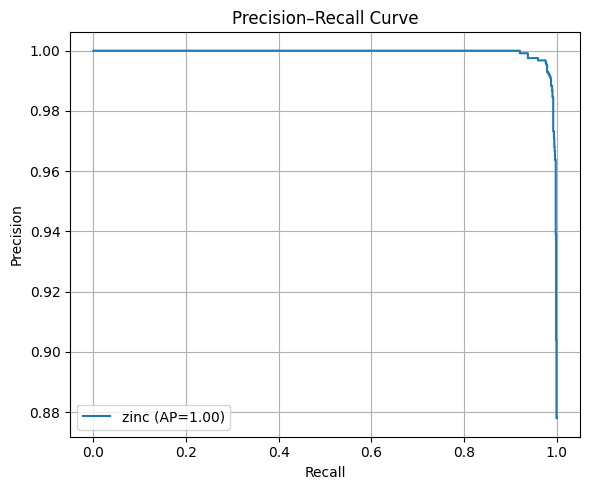

In [ ]:
class_names = ["background", "zinc"]
plot_pr_curves(data["pr_data"], class_names)

In [ ]:
#iou histogram
def plot_iou_histogram(ious):
    plt.figure(figsize=(6, 4))
    plt.hist(ious, bins=20, range=(0, 1), color='skyblue', edgecolor='black')
    plt.title("IoU Histogram")
    plt.xlabel("IoU")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

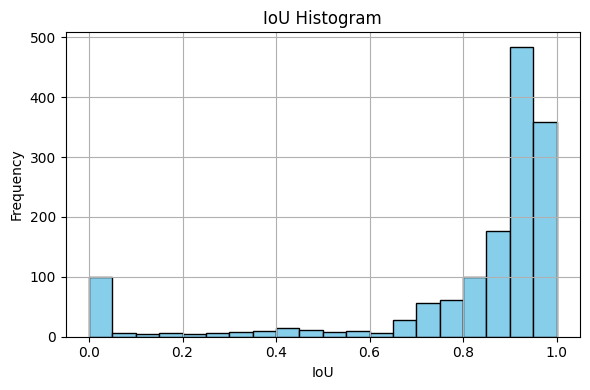

In [ ]:
plot_iou_histogram(data["ious"])

In [ ]:
#confidence score histgram
def plot_confidence_histogram(confidences):
    plt.figure(figsize=(6, 4))
    plt.hist(confidences, bins=20, range=(0, 1), color='salmon', edgecolor='black')
    plt.title("Confidence Score Histogram")
    plt.xlabel("Confidence")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

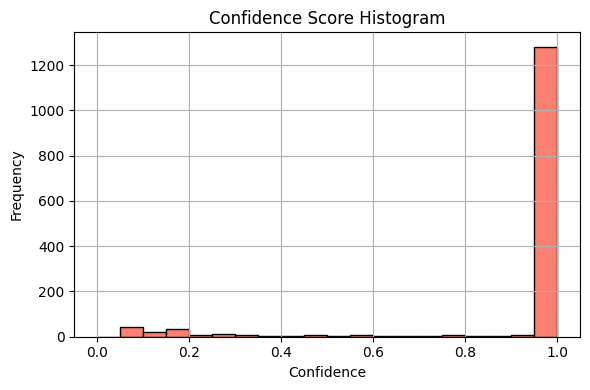

In [ ]:
plot_confidence_histogram(data["confidences"])

In [ ]:
#normalised confusion matrix
def detection_confusion_matrix_normalised(preds, gts, iou_thresh=0.5):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import numpy as np

    y_true = []
    y_pred = []

    for pred_boxes, gt_boxes in zip(preds, gts):
        pred_boxes = pred_boxes if isinstance(pred_boxes, torch.Tensor) else torch.tensor(pred_boxes)
        gt_boxes = gt_boxes if isinstance(gt_boxes, torch.Tensor) else torch.tensor(gt_boxes)

        if len(pred_boxes) == 0 and len(gt_boxes) == 0:
            continue
        if len(pred_boxes) == 0:
            y_true.extend([1] * len(gt_boxes))
            y_pred.extend([0] * len(gt_boxes))
            continue
        if len(gt_boxes) == 0:
            y_true.extend([0] * len(pred_boxes))
            y_pred.extend([1] * len(pred_boxes))
            continue

        ious = box_iou(pred_boxes, gt_boxes)
        matched_gt = set()

        for i in range(len(pred_boxes)):
            max_iou, max_idx = ious[i].max(0)
            if max_iou >= iou_thresh and max_idx.item() not in matched_gt:
                y_true.append(1)
                y_pred.append(1)
                matched_gt.add(max_idx.item())
            else:
                y_true.append(0)
                y_pred.append(1)

        for j in range(len(gt_boxes)):
            if j not in matched_gt:
                y_true.append(1)
                y_pred.append(0)

    cm = confusion_matrix(y_true, y_pred, labels=[1, 0]).astype(np.float32)

    #normalising by rows (true labels)
    cm_sum = cm.sum(axis=1, keepdims=True)
    cm_sum[cm_sum == 0] = 1  #to prevent division by zero
    cm_normalised = cm / cm_sum

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalised,
                                   display_labels=["Zinc", "Not Zinc"])
    disp.plot(cmap="Blues", values_format=".2f")
    plt.title("Normalised Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return cm, cm_normalised

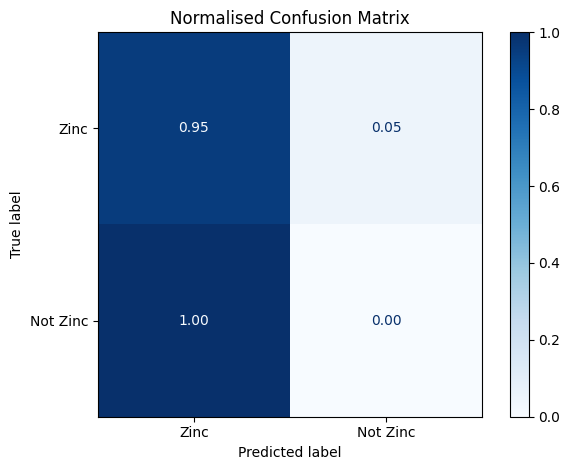

In [ ]:
cm_raw, cm_norm = detection_confusion_matrix_normalised(data["all_pred_boxes"], data["all_gt_boxes"])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#FP Heatmap
def plot_fp_heatmap(fp_boxes, image_size=(1024, 1024), downscale=4):
    h, w = image_size
    heatmap = np.zeros((h // downscale, w // downscale), dtype=np.float32)

    for box in fp_boxes:
        if isinstance(box, torch.Tensor):
            box = box.numpy()

        x_center = int((box[0] + box[2]) / 2)
        y_center = int((box[1] + box[3]) / 2)

        if 0 <= x_center < w and 0 <= y_center < h:
            heatmap[y_center // downscale, x_center // downscale] += 1

    if np.max(heatmap) > 0:
        heatmap = heatmap / np.max(heatmap)

    plt.figure(figsize=(6, 6))
    plt.imshow(heatmap, cmap="Reds", interpolation="nearest")
    plt.colorbar()
    plt.title("False Positive Heatmap")
    plt.tight_layout()
    plt.show()

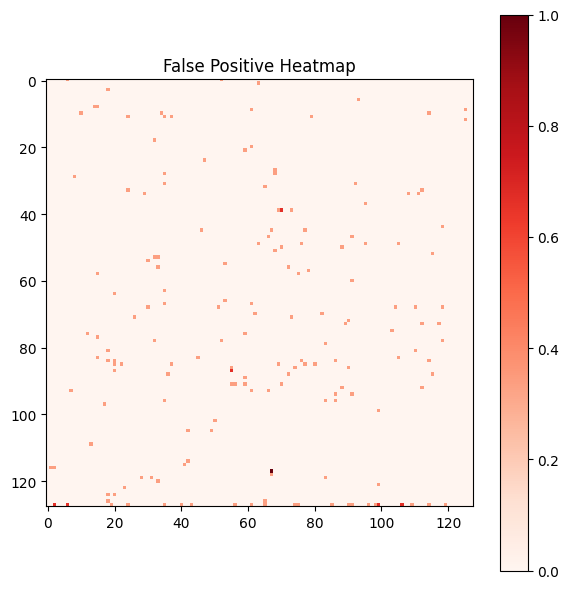

In [ ]:
plot_fp_heatmap(data["fp_boxes"], image_size=(1024, 1024), downscale=8)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#FN Heatmap
def plot_fn_heatmap(fn_boxes, image_size=(1024, 1024), downscale=4):
    h, w = image_size
    heatmap = np.zeros((h // downscale, w // downscale), dtype=np.float32)

    for box in fn_boxes:
        if isinstance(box, torch.Tensor):
            box = box.numpy()

        x_center = int((box[0] + box[2]) / 2)
        y_center = int((box[1] + box[3]) / 2)

        if 0 <= x_center < w and 0 <= y_center < h:
            heatmap[y_center // downscale, x_center // downscale] += 1

    if np.max(heatmap) > 0:
        heatmap = heatmap / np.max(heatmap)

    plt.figure(figsize=(6, 6))
    plt.imshow(heatmap, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    plt.title("False Negative Heatmap")
    plt.tight_layout()
    plt.show()

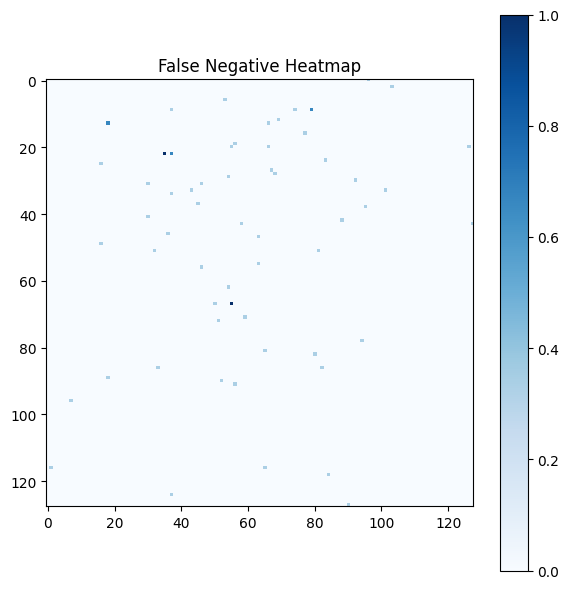

In [ ]:
plot_fn_heatmap(data["fn_boxes"], image_size=(1024, 1024), downscale=8)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

#visualising the detections
def visualize_predictions(model, dataset, device, class_names, num_samples=3, score_thresh=0.5):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    for idx in indices:
        sample = dataset[idx]
        if sample is None:
            continue
        image, target = sample
        image_np = image.permute(1, 2, 0).numpy()
        img_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)[0]

        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(image_np)

        #plotting the ground truth boxes (green)
        for box, label in zip(target["boxes"], target["labels"]):
            x1, y1, x2, y2 = box.tolist()
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, f"GT: {class_names[label]}", color='lime', fontsize=10)

        #plotting the predicted boxes (red)
        for box, label, score in zip(output["boxes"], output["labels"], output["scores"]):
            if score < score_thresh:
                continue
            x1, y1, x2, y2 = box.tolist()
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y2 + 10, f"Pred: {class_names[label]} ({score:.2f})", color='red', fontsize=10)

        plt.title(f"Sample {idx} — Green: GT, Red: Prediction")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

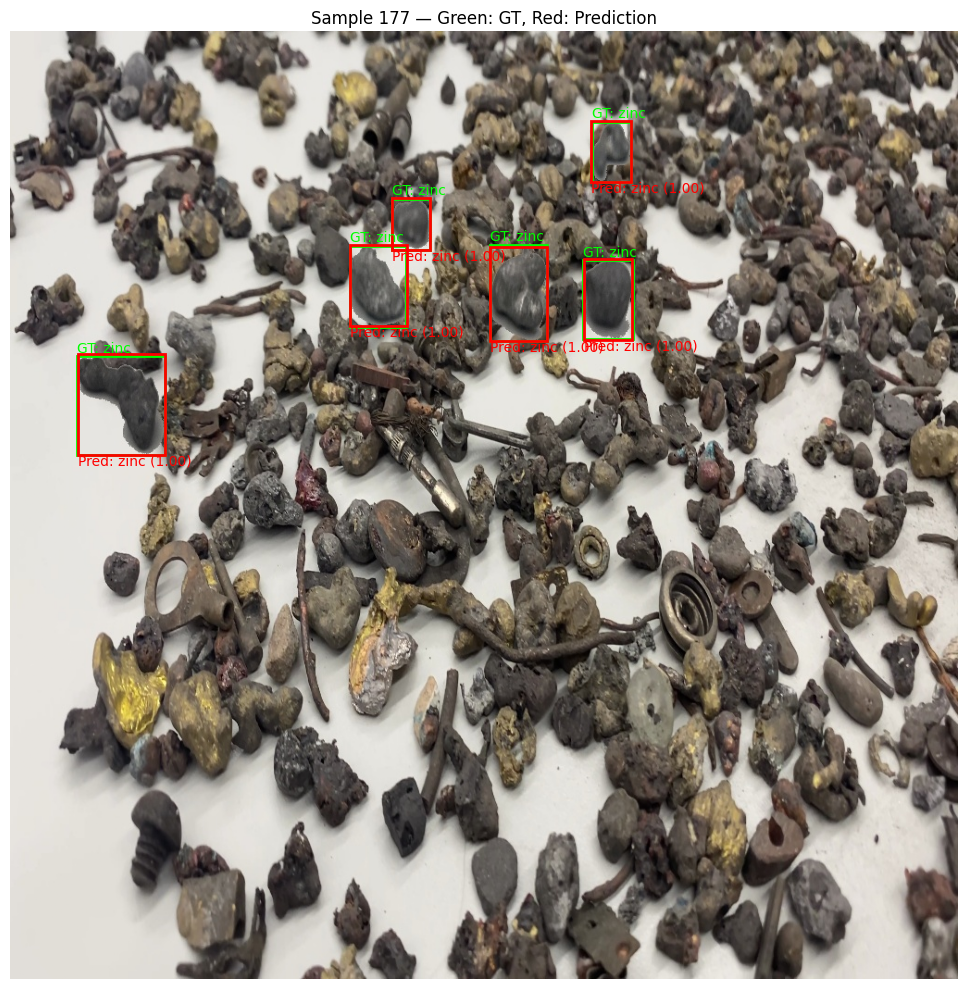

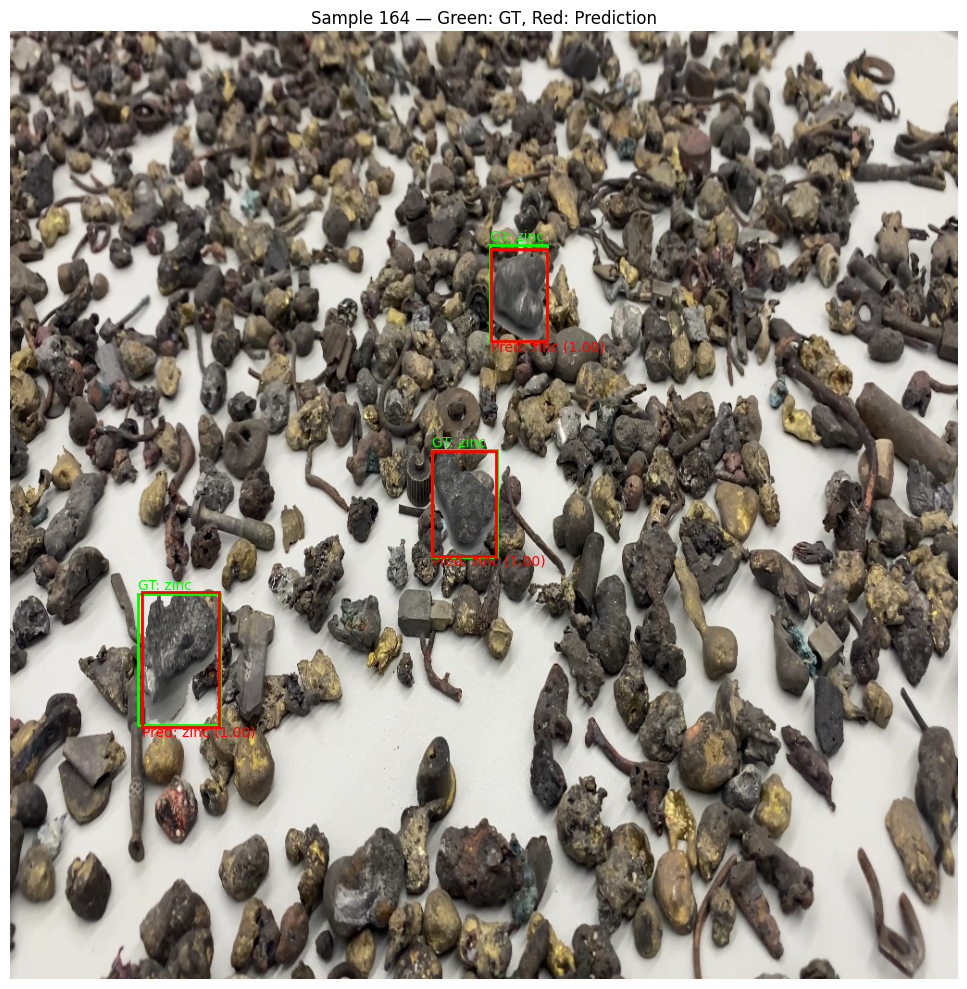

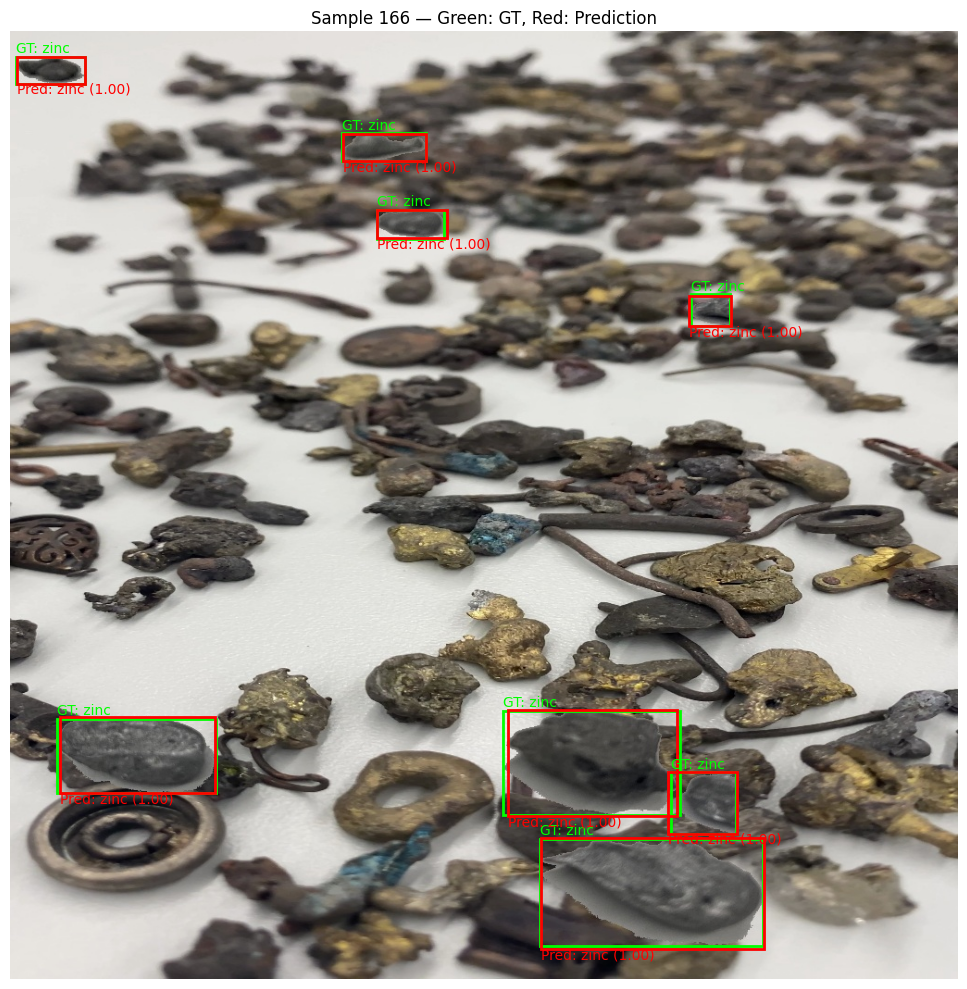

In [ ]:
visualize_predictions(model, test_dataset, device, class_names=["background", "zinc"], num_samples=3)